# Download data

In [ ]:
# ------------------------------------------ #
# GETTING DATA FROM DATA MENDELEY REPOSITORY #
# ------------------------------------------ #
!rm -f cammesa_db_2012_2018.csv
!wget --no-verbose https://data.mendeley.com/public-files/datasets/92g8n7pjp2/files/df476d46-77c7-49bb-a456-2b4693c38486/file_downloaded > /dev/null
!mv file_downloaded cammesa_db_2012_2018.csv
!ls -lh --color=auto

2023-05-23 12:29:15 URL:https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/e2683ab3-3c59-42ad-a832-779d49fe766b [4271457/4271457] -> "file_downloaded" [1]
total 12M
-rw-r--r-- 1 1000 1000 415K Jun  5  2021 cammesa_daily.csv
-rw-r--r-- 1 root root 4.1M Mar 21 14:25 cammesa_db_2012_2018.csv
-rw-r--r-- 1 1000 1000 5.9M Jun  5  2021 cammesa_hourly.csv
-rw-r--r-- 1 1000 1000  15K Jun  5  2021 cammesa_monthly.csv
-rw-r--r-- 1 root root 1.4M Jun  5  2021 CAMMESA.tgz
-rw-r--r-- 1 1000 1000  63K Jun  5  2021 cammesa_weekly.csv
drwxr-xr-x 1 root root 4.0K May 19 13:32 sample_data


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# ---------------------------------------------- #
# IMPORTING DATA AND GENERATING VARIABLE 'isWrk' #
# ---------------------------------------------- #
df = pd.read_csv('cammesa_db_2012_2018.csv')
df['date'] = [f'{datetime[:4]}-{datetime[5:7]:02}-{datetime[8:10]:02}' for datetime in df['datetime']]
df['date'] = pd.to_datetime(df['date'])
df['day'] = [date.day_name() for date in df['date']]
df['Wrk'] = [(day!='Sunday' and day!='Saturday') and not holiday for day, holiday in zip(df['day'], df['Holiday'])]
df.head()


# -------------------------------------- #
# TRANSFORMING FROM HOURLY TO DAILY DATA #
# -------------------------------------- #
import numpy as np
step=24
data = {
        'date':[],
        'EMAE':[],
        'Wrk':[],
        'Temp':[],
        'Hum': [],
        'DemGBA':[],
        }
for i in range(0, df.shape[0], step):
  f = min(i+step, df.shape[0])
  assert len(set(df["day"].iloc[i:f]))==1
  assert len(set(df["EMAE"].iloc[i:f]))==1
  assert len(set(df["Wrk"].iloc[i:f]))==1
  assert len(set(df["date"].iloc[i:f]))==1
  data['EMAE'].append(df['EMAE'][i])
  data['Wrk'].append(1 if df['Wrk'][i] else 0)
  data['date'].append(df['date'][i])
  data['Temp'].append(np.average(df['Temp'].iloc[i:f]))
  data['Hum'].append(np.average(df['Hum'].iloc[i:f]))
  data['DemGBA'].append(np.sum(df['DemGBA'].iloc[i:f]))


df = pd.DataFrame(data)

# REMOVE LEAP DAYS
# df = df[ np.array([not '02-29' in str(date) for date in df['date']])]



df = df.set_index('date')
df.index = df.index.to_period(freq='D')

shifted = df.shift(1)
shifted.columns = [f'l.{column}' for column in shifted.columns]
df = pd.concat([df,shifted], axis=1)
df = df.dropna()
print(df.shape)
df.head()

(2556, 10)


,EMAE,Wrk,Temp,Hum,DemGBA,l.EMAE,l.Wrk,l.Temp,l.Hum,l.DemGBA
date,,,,,,,,,,
2012-01-02,145.95,1,27.337500,0.575000,134833,145.95,0.0,24.295833,0.635000,99924.0
2012-01-03,145.95,1,23.150000,0.665833,137700,145.95,1.0,27.337500,0.575000,134833.0
2012-01-04,145.95,1,23.266667,0.601667,132699,145.95,1.0,23.150000,0.665833,137700.0
2012-01-05,145.95,1,27.508333,0.490000,144844,145.95,1.0,23.266667,0.601667,132699.0
2012-01-06,145.95,1,28.808333,0.450000,151924,145.95,1.0,27.508333,0.490000,144844.0


# OLD

In [ ]:
!rm -f CAMMESA.tgz
!wget https://cs.uns.edu.ar/~mmaisonnave/resources/tesis/CAMMESA.tgz  >> /dev/null
!tar zxvf CAMMESA.tgz >> /dev/null

--2023-05-23 12:24:34--  https://cs.uns.edu.ar/~mmaisonnave/resources/tesis/CAMMESA.tgz
Resolving cs.uns.edu.ar (cs.uns.edu.ar)... 200.49.226.11
Connecting to cs.uns.edu.ar (cs.uns.edu.ar)|200.49.226.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1375608 (1.3M) [application/x-gzip]
Saving to: ‘CAMMESA.tgz’

CAMMESA.tgz         100%[===================>]   1.31M  1.15MB/s    in 1.1s    

2023-05-23 12:24:36 (1.15 MB/s) - ‘CAMMESA.tgz’ saved [1375608/1375608]



In [ ]:
import pandas as pd
old = pd.read_csv('cammesa_daily.csv')


month2number = {
    'enero':1,
    'febrero':2,
    'marzo':3,
    'abril':4,
    'mayo':5,
    'junio':6,
    'julio':7,
    'agosto':8,
    'septiembre':9,
    'octubre':10,
    'noviembre':11,
    'diciembre':12
}

old['Date'] = [f'{row[3]}-{month2number[row[1]]}-{row[0]}' for row in old.values]

old['Date'] = pd.to_datetime(old['Date'])

# df['Date'] = np.array([f'{year}-{month2number[month]}-01' for year,month in zip(df['Year'],df['Month'])])

#remove leap days
old = old[~((old['Month']=='febrero') & (old['Day']==29))]


del old['Month']
del old['Year']



old['Summer'] = [1 if season=='Summer' else 0 for season in old['Season']]
old['Winter'] = [1 if season=='Winter'  else 0 for season in old['Season']]
old['isSpecialDay'] = [1 if isSpecial=="Y"  else 0 for isSpecial in old['isSpecialDay']]
old['isHoliday'] = [1 if isHoliday=="Y"  else 0 for isHoliday in old['isHoliday']]
old['isWeekend'] = [1 if weekday=="Sunday" or weekday=="Saturday"  else 0 for weekday in old['Weekday']]

del old['Season']
del old['Weekday']
del old['Day']
del old['isSpecialDay']
del old['Ster']
del old['Summer']
del old['Winter']
# del df['Hour']
# df = df[['Date', 'DemGBA', 'Temp', 'EMAE', 'vy', 'vx', 'Hum', 'Pres']]


old["Wrk"] = [0 if isWeek or isHol else 1 for isWeek,isHol in zip(old["isWeekend"], old["isHoliday"])]
del old['isWeekend']


old = old.set_index('Date')
old.index = old.index.to_period(freq='D')
print(old.shape)
old

(2555, 10)


,DemGBA,Temp,isHoliday,EMAE,vy,vx,GHI,Hum,Pres,Wrk
Date,,,,,,,,,,
2012-01-01,99924.0,24.295833,1,145.95,0.769583,3.617083,384.250000,0.635000,1015.370833,0
2012-01-02,134833.0,27.337500,0,145.95,1.010833,4.014583,375.875000,0.575000,1012.525000,1
2012-01-03,137700.0,23.150000,0,145.95,-1.170833,6.880417,359.708333,0.665833,1014.275000,1
2012-01-04,132699.0,23.266667,0,145.95,2.570833,5.254167,382.250000,0.601667,1016.408333,1
2012-01-05,144844.0,27.508333,0,145.95,4.598750,-0.172083,377.291667,0.490000,1013.479167,1
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,165301.0,27.533333,0,144.80,5.851250,-1.034583,157.166667,0.682917,1006.829167,1
2018-12-28,161804.0,26.729167,0,144.80,2.013333,8.611667,301.708333,0.684167,1008.508333,1
2018-12-29,139927.0,26.575000,0,144.80,3.351667,3.026250,263.333333,0.730000,1005.650000,0


# Ajuste de los modelos

## ARIMA

***OLD RESULTS:***

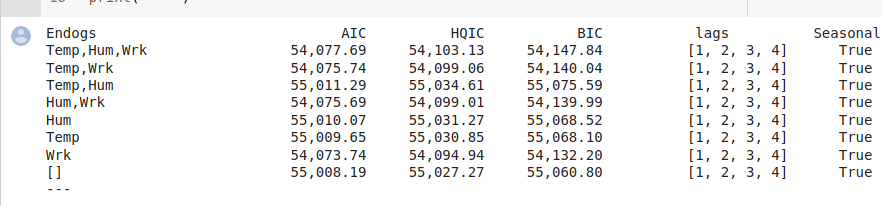

In [ ]:
from statsmodels.tsa.ar_model import AutoReg


endog='DemGBA'

print(f'Endogenous Variables         AIC           HQIC           BIC               lags                 Seasonal')

lags=[1,2,3,4, 5]
for seasonal in [ True]:
  for exog_vars in [['l.Temp', 'l.Hum', 'Wrk'], ['l.Temp', 'l.Wrk'],['l.Temp', 'l.Hum'],['l.Hum', 'Wrk'],['l.Hum'], ['l.Temp'],['Wrk'], []]:
    if len(exog_vars)>0:
      res = AutoReg(endog=df['DemGBA'], lags = lags, exog=df[exog_vars],seasonal=seasonal, ).fit()
    else:
      res = AutoReg(endog=df['DemGBA'], lags = lags, seasonal=seasonal, ).fit()
    print(f"{','.join(exog_vars) if len(exog_vars)>0 else '[]':20}        "\
          f"{res.aic:10,.2f}    {res.hqic:10,.2f}    {res.bic:10,.2f}         "\
          f" {lags}      {seasonal}")
  print('---')

Endogenous Variables         AIC           HQIC           BIC               lags                 Seasonal
l.Temp,l.Hum,Wrk             53,455.20     53,489.11     53,548.71          [1, 2, 3, 4, 5]      True
l.Temp,l.Wrk                 53,613.98     53,645.77     53,701.65          [1, 2, 3, 4, 5]      True
l.Temp,l.Hum                 53,822.23     53,854.02     53,909.89          [1, 2, 3, 4, 5]      True
l.Hum,Wrk                    53,468.16     53,499.95     53,555.82          [1, 2, 3, 4, 5]      True
l.Hum                        53,835.55     53,865.23     53,917.37          [1, 2, 3, 4, 5]      True
l.Temp                       53,821.70     53,851.37     53,903.52          [1, 2, 3, 4, 5]      True
Wrk                          53,466.62     53,496.30     53,548.44          [1, 2, 3, 4, 5]      True
[]                           53,833.55     53,861.11     53,909.53          [1, 2, 3, 4, 5]      True
---


## LINEAR REGRESSION

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant



import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rng = np.random.default_rng(seed=64429)
data= {'Endogenous Variables':[], 'AIC':[], }
repetitions=20


for vars in [['l.Temp', 'l.Hum', 'Wrk'], ['l.Temp', 'Wrk'],['l.Temp', 'l.Hum'],['l.Hum', 'Wrk'],['l.Hum'], ['l.Temp'],['Wrk'],]:
  X = df[vars]
  y = df[['DemGBA']]

  regr = OLS(y, add_constant(X)).fit()

  data['AIC'].append(regr.aic)
  data['Endogenous Variables'].append(list(vars))
pd.DataFrame(data)
# print('Endogenous Variables'+' '*26+'MSE')
# for vars, auxdf in pd.DataFrame(data).groupby(by='Endogenous Variables'):
#   print(f"{str(list(vars)):29} {np.average(auxdf['MSE']):,}")

,Endogenous Variables,AIC
0,"[l.Temp, l.Hum, Wrk]",57399.508559
1,"[l.Temp, Wrk]",57397.645885
2,"[l.Temp, l.Hum]",58065.967190
3,"[l.Hum, Wrk]",57461.956817
4,[l.Hum],58115.143857
5,[l.Temp],58064.240451
6,[Wrk],57464.810037


# Forecasting

**OLD RESULTS**

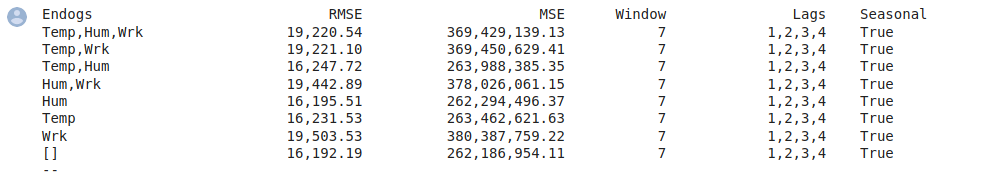

In [ ]:
import numpy as np
a = np.array([1,2,3])
a.mean()

2.0

In [ ]:
from prompt_toolkit.shortcuts.prompt import E
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import numpy as np

from scipy.stats import t
def confidence_interval(x:list, confidence = 0.95):
  x = np.array(x)
  m = x.mean()
  s = x.std()
  dof = len(x)-1
  t_crit = np.abs(t.ppf((1-confidence)/2,dof))
  return (m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)))


rng = np.random.default_rng(seed=64429)


# print(f'Endogs                            RMSE                     MSE      Window               Lags    Seasonal')

data = {'vars':[], 'mse': [], 'cut': [],}
lags = [1,2,3, 4, 5]
repetitions=20
for _ in range(repetitions):
  cut_year_in = rng.integers(low=0, high=365,size=1)[0]
  for seasonal in [True]:
    for window in [7]:

      train = df.iloc[:-cut_year_in].iloc[:-window,:]
      test  = df.iloc[:-cut_year_in].iloc[-window:,:]

      endog='DemGBA'
      for exog_vars in [['l.Temp', 'l.Hum', 'Wrk'], ['l.Temp', 'Wrk'],['l.Temp', 'l.Hum'],['l.Hum', 'Wrk'],['l.Hum'], ['l.Temp'],['Wrk'], []]:

        if len(exog_vars)>0:
          res = AutoReg(endog=train[endog], lags = lags, exog=train[exog_vars],seasonal=seasonal, ).fit()
          yhat = res.predict(start=len(train), end=len(train)+window-1, exog_oos=test[exog_vars], dynamic=True)
        else:
          res = AutoReg(endog=train[endog], lags = lags, seasonal=seasonal, ).fit()
          yhat = res.predict(start=len(train), end=len(train)+window-1, dynamic=True)

        rmse_=rmse(test[endog], yhat)
        mse=mean_squared_error(test[endog], yhat)
        data['vars'].append(tuple(exog_vars))
        data['mse'].append(mse)
        data['cut'].append(cut_year_in)
    #     print(f"{','.join(exog_vars) if len(exog_vars)>0 else '[]':20}        {rmse_:>10,.2f}"\
    #           f"    {mse:>20,.2f}          {window:>2}       {(','.join([str(elem) for elem in lags])):>12}    {seasonal}")

    # print('--')


print('vars'+' '*25+'MSE'+' '*19+'CI')
for vars, auxdf in pd.DataFrame(data).groupby(by='vars'):
  ini, fin = confidence_interval(list(auxdf['mse']))
  print(f"{str(list(vars)):28} {np.average(auxdf['mse']):,.2f}"+' '*8+f'({ini:,},{fin:,})')

vars                         MSE                   CI
[]                           242,795,803.78        (130,668,754.35900296,354,922,853.2047734)
['Wrk']                      227,003,567.08        (146,453,822.87841243,307,553,311.2756745)
['l.Hum']                    244,398,637.10        (130,524,598.60302591,358,272,675.60133344)
['l.Hum', 'Wrk']             230,282,529.02        (148,572,493.24888217,311,992,564.7867166)
['l.Temp']                   240,778,422.67        (129,183,882.48319857,352,372,962.8528298)
['l.Temp', 'Wrk']            226,344,788.74        (143,962,610.30977634,308,726,967.1604446)
['l.Temp', 'l.Hum']          244,109,905.44        (129,960,191.18876693,358,259,619.68469596)
['l.Temp', 'l.Hum', 'Wrk']   230,828,717.97        (148,110,491.19677544,313,546,944.7387802)


# AUTO ARIMA

In [ ]:
import pmdarima as pmdarima
model = pmdarima.auto_arima(df['DemGBA'], seasonal=True, m=7)
model.summary()


# OLD RESULTS
# ARIMA

#  ARIMA(4,1,3)(2,0,2)[7]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2556
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -27358.243
Date:                           Tue, 23 May 2023   AIC                          54732.487
Time:                                   14:55:52   BIC                          54779.253
Sample:                               01-02-2012   HQIC                         54749.446
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0531      0.021      2.537      0.011       0.012       0.094
ar.L2         -0.2500      0.021    -12.026      0.000      -0.291      -0.209
ar.L3         -0.1264      0.019     -6.519      0.000      -0.164      -0.088
ar.L4         -0.1338      0.021     -6.486      0.000      -0.174      -0.093
ar.L5         -0.1869      0.021     -8.834      0.000      -0.228      -0.145
ar.S.L7        0.2422      0.021     11.606      0.000       0.201       0.283
ar.S.L14       0.3486      0.018     18.936      0.000       0.312       0.385
sigma2      1.406e+08   2.16e-11   6.52e+18      0.000    1.41e+08    1.41e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               348.49
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.14
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:

 model

ARIMA(order=(5, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

# Regresiones lineales

In [ ]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
# y=train['DemGBA']
# x=train[['Temp','Hum','Wrk']]
# x = sm.add_constant(x) # adding a constant
# lm = sm.OLS(y,x).fit() # fitting the model

# #lm.predict(x)
# lm.summary()


# In [2]
# import statsmodels.api as sm

# X_test=test[['Temp','Hum','Wrk']]
# X_test = sm.add_constant(X_test) # adding a constant

# yhat = lm.predict(X_test)
# #yhat
# rmse_=rmse(test[endog], yhat)
# mse=mean_squared_error(test[endog], yhat)
# mse
# # old value:
# # 289487758.7546725

503051.82002960815

In [ ]:
# x=train[['Temp','Wrk']]
# x = sm.add_constant(x) # adding a constant
# lm = sm.OLS(y,x).fit() # fitting the model

# #lm.predict(x)
# lm.summary()

# X_test=test[['Temp','Wrk']]
# X_test = sm.add_constant(X_test) # adding a constant

# yhat = lm.predict(X_test)
# #yhat
# rmse_=rmse(test[endog], yhat)
# mse=mean_squared_error(test[endog], yhat)
# mse

# # old value
# # 292743334.166985

508608.22706233914

In [ ]:
# x=train[['Temp']]
# x = sm.add_constant(x) # adding a constant
# lm = sm.OLS(y,x).fit() # fitting the model

# #lm.predict(x)
# lm.summary()

# X_test=test[['Temp']]
# X_test = sm.add_constant(X_test) # adding a constant

# yhat = lm.predict(X_test)
# #yhat
# rmse_=rmse(test[endog], yhat)
# mse=mean_squared_error(test[endog], yhat)
# mse

# # old value
# # 546328776.5171226

948381.9767118525

In [ ]:
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rng = np.random.default_rng(seed=64429)
data= {'Endogenous Variables':[], 'MSE':[], 'window':[], 'cut':[]}
repetitions=20

for _ in range(repetitions):
  cut_year_in = rng.integers(low=0, high=365,size=1)[0]
  for window in [7]:

    for vars in [['l.Temp', 'l.Hum', 'Wrk'], ['l.Temp', 'Wrk'],['l.Temp', 'l.Hum'],['l.Hum', 'Wrk'],['l.Hum'], ['l.Temp'],['Wrk'],]:
      X_train = df.iloc[:-cut_year_in].iloc[:-window,:][vars]
      y_train = df.iloc[:-cut_year_in].iloc[:-window,:][['DemGBA']]
      X_test  = df.iloc[:-cut_year_in].iloc[-window:,:][vars]
      y_test = df.iloc[:-cut_year_in].iloc[-window:,:][['DemGBA']]

      model = LinearRegression()
      model.fit(X_train, y_train)

      yhat = model.predict(X_test)
      # train = sm.add_constant(X_train)
      # lm = sm.OLS(y_train,X_train).fit()
      # yhat = lm.predict(X_test)
      mse = mean_squared_error(y_test, yhat)
      data['MSE'].append(mse)
      data['Endogenous Variables'].append(tuple(vars))
      data['window'].append(window)
      data['cut'].append(cut_year_in)

print('Endogenous Variables'+' '*26+'MSE'+' '*19 + 'CI')
for vars, auxdf in pd.DataFrame(data).groupby(by='Endogenous Variables'):
  ini, fin = confidence_interval(list(auxdf['MSE']))
  print(f"{str(list(vars)):29} {np.average(auxdf['MSE']):25,}"+' '*8+f'({ini:<22,},{fin:,})')

Endogenous Variables                          MSE                   CI
['Wrk']                            459,148,906.13201773        (291,122,733.63997185  ,627,175,078.6240636)
['l.Hum']                           568,970,208.9257091        (373,144,063.0374247   ,764,796,354.8139936)
['l.Hum', 'Wrk']                    458,693,930.7754267        (290,826,958.81477475  ,626,560,902.7360786)
['l.Temp']                          544,874,815.8283508        (342,430,492.5343542   ,747,319,139.1223474)
['l.Temp', 'Wrk']                  438,062,536.70992136        (272,121,563.58455443  ,604,003,509.8352883)
['l.Temp', 'l.Hum']                 545,797,088.2874951        (342,595,776.89520645  ,748,998,399.6797838)
['l.Temp', 'l.Hum', 'Wrk']          440,757,896.9773342        (272,254,042.51328975  ,609,261,751.4413786)


In [ ]:
# vars                                   window                    avg RMSE                    MSE
# Temp,Hum,Wrk                  		 7		840.3568722707041		606,840.8500495497
# Temp,Wrk                      		 7		1,579.2915114910752		2,502,740.180471883
# Temp,Hum                      		 7		774.419218863958		1,072,263.669604333
# Hum,Wrk                       		 7		871.149737748942		429,995.33436274837
# Hum                           		 7		763.4880959408973		923,440.955557714
# Temp                          		 7		1,527.2640576143535		3,435,952.236507993
# Wrk                           		 7		2,859.427866500739		11,150,422.099275736

array([1396.88645221, 1070.14867679, 1131.56439202, 1106.76162641,
        965.05311309, 1221.67944128, 1730.3735113 ])

In [ ]:
df.to_excel("cammesa.xlsx")
from google.colab import files
files.download("cammesa.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>